In [1]:
import numpy as np
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import yaml
from operator import itemgetter
import pandas as pd
import os
from matplotlib import rc
rc('text', usetex=True)
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from scipy import interpolate


import figures, growth


# General diagram for n=3, linear growth

[A] Thickness of the uppermost mushy layer and [B] volume-average porosity for a _linear growth_ as function of the final growth rate and inner core radius.

In [2]:
def diagram_data_residual_porosity(folder_main, output="data.csv"):
    columns = ["Ric_adim", "tau_ic", "exp", "sum_phi", "delta", "Nmax", "folder", "remarks"]
    df = pd.DataFrame(columns=columns)

    def add_value(df, ric, tau, exp, phi, delta, Nmax, phi_r, phi_t, folder="", remarks=""):
        df_add = pd.DataFrame({"Ric_adim":[ric], "tau_ic":[tau], "exp":[exp], "sum_phi":[phi], "delta":[delta], 
                               "Nmax": Nmax, "phi_r": phi_r, "phi_top": phi_t, "folder":folder, "remarks": remarks})
        df = df.append(df_add)
        return df

    list_subfolder = os.listdir(folder_main)
    print("Looking through folder {}".format(folder_main))
    for subfolder_name in list_subfolder:
        
        
        if os.path.isdir(folder_main + "/" + subfolder_name):
            file_stat, param, timesteps = figures.extract_files(folder_main+"/"+subfolder_name)
        
            data = pd.read_csv(file_stat, sep=" ", index_col=False)
            
            if data["thickness_boundary"].iloc[-1] < 1e-12:
                print("no boundary for R {}, dot_R {}: folder {}".format(param["Ric_adim"], param['coeff_velocity'], folder_main + "/" +subfolder_name))
            elif np.abs(data["radius"].iloc[-1] -param["Ric_adim"])/param["Ric_adim"]>1e-2:
                print("Run not finished for R {}, dot_R {}: folder {}".format(param["Ric_adim"], param['coeff_velocity'], folder_main + "/" +subfolder_name))
                print(data["radius"].iloc[-1], param["Ric_adim"])
            else: 
                name_max = max(timesteps.items(), key=itemgetter(1))[0] 
                data_max = pd.read_csv(name_max, sep=" ")
                index_bottom = abs(data_max['radius'] - 0.05*param["Ric_adim"]).idxmin()
                phi_r = data_max["porosity"].iloc[index_bottom]
                index_top = abs(data_max['radius'] - 0.90*param["Ric_adim"]).idxmin()
                phi_t = data_max["porosity"].iloc[index_top]
                df = add_value(df, param["Ric_adim"], param['time_max'], param['growth_rate_exponent'], 
                                 data["sum_phi"].iloc[-1], data["thickness_boundary"].iloc[-1], 
                                 data["radius_size"].iloc[-1], phi_r, phi_t, folder=subfolder_name)
        else: print("oups, not a folder: {}".format(folder_main + "/" + subfolder_name))

    df["dot_r"] = df["Ric_adim"]/df["tau_ic"]*df["exp"] 
    return df




def diagram(df, ylim=[-2, 2.5], xlim=[-4, 3]):
    df["dot_r"] = df["Ric_adim"]/df["tau_ic"]*df["exp"]
    x = np.log(np.array(df["dot_r"].values).astype(float))/np.log(10.)
    #x = np.log(np.array(df["coeff_velocity"].values).astype(float))/np.log(10.) # growth rate
    y = np.log(np.array(df["Ric_adim"].values).astype(float))/np.log(10.) # radius IC
    #delta = np.array(df["delta"].values).astype(float) # 
    delta = np.log(np.array(df["delta"].values).astype(float))/np.log(10.)
    #delta = np.log(np.array(df["delta"].values).astype(float)*np.array(df["Ric_adim"].values).astype(float))/np.log(10.)
    phi = np.array(df["sum_phi"].values).astype(float) # 
    phir = np.array(df["phi_r"].values).astype(float) # 
    #phi = np.log(np.array(df["sum_phi"].values).astype(float))/np.log(10.)
    
    N=50
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=[10, 3])
#    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=[10, 3])
    cmap = plt.cm.magma
    cntr1 = ax[0].tricontourf(x, y, delta, levels=np.linspace(-2, 5, N),  cmap=cmap)
    cntr2 = ax[1].tricontourf(x, y, phi, levels=np.linspace(0, 0.4, N),  cmap=cmap)
#    cntr3 = ax[2].tricontourf(x, y, phir, levels=np.linspace(0, 0.4, N),  cmap=cmap)
    cbar1 = plt.colorbar(cntr1, ax=ax[0], ticks=np.linspace(-2, 5, 8))
    cbar1.ax.set_ylabel("$\ln_{10}(\delta_{ul}/\delta$)")
    cbar2 = plt.colorbar(cntr2, ax=ax[1], ticks=[0., 0.1, 0.2, 0.3, 0.4])
    cbar2.ax.set_ylabel(r"$<\phi>$")
#    cbar2 = plt.colorbar(cntr3, ax=ax[2], ticks=[0., 0.1, 0.2, 0.3, 0.4])
#    cbar2.ax.set_ylabel(r"$\phi_c$")
    ax[0].set_title("Thickness of upper layer")
    ax[1].set_title("Average porosity")
#    ax[2].set_title("Porosity at center")
    ax[0].set_xlabel(r"$\ln_{10}(\dot{R}_{{ic}}( \tau_{{ic}})/V_D)$")
    ax[0].set_ylabel(r"$\ln_{10}(R_{{ic}}( \tau_{{ic}})/ \delta)$")
    ax[1].set_xlabel(r"$\ln_{10}(\dot{R}_{{ic}}( \tau_{{ic}})/V_D)$")
#    ax[2].set_xlabel(r"$\ln_{10}\dot{R}_{{ic}}( \tau_{{ic}})$")

    ax[0].set_ylim(ylim)
    ax[0].set_xlim(xlim)
    return fig, ax

In [3]:
folder = "/home/lasbleis-m/Research/output_mush/diag_random_n3_all/"
values = diagram_data_residual_porosity(folder, "diag.csv")
#values["dot_r"] = values["Ric_adim"]/values["tau_ic"]*values["exp"] 

values.to_csv("diag_linear.csv", index=False)

Looking through folder /home/lasbleis-m/Research/output_mush/diag_random_n3_all/


/home/lasbleis-m/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


oups, not a folder: /home/lasbleis-m/Research/output_mush/diag_random_n3_all//data.csv
Run not finished for R 947.0982049419993, dot_R 9.422017206081331e-05: folder /home/lasbleis-m/Research/output_mush/diag_random_n3_all//exp_1.00e+00_coeff_9.42e-05_radius_9.47e+02
645.79 947.0982049419993
oups, not a folder: /home/lasbleis-m/Research/output_mush/diag_random_n3_all//diag_random.csv
Run not finished for R 990.1117469153911, dot_R 0.00011101962942087649: folder /home/lasbleis-m/Research/output_mush/diag_random_n3_all//exp_1.00e+00_coeff_1.11e-04_radius_9.90e+02
488.32 990.1117469153911
Run not finished for R 0.0010112211334163271, dot_R 414.9533637921495: folder /home/lasbleis-m/Research/output_mush/diag_random_n3_all//exp_1.00e+00_coeff_4.15e+02_radius_1.01e-03
0.00062696 0.0010112211334163271


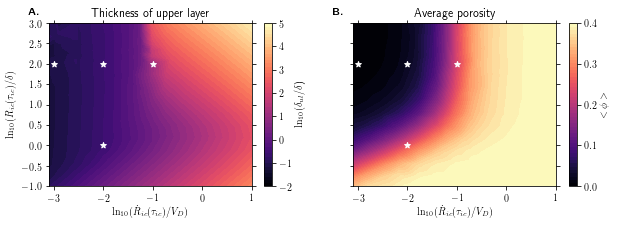

In [4]:
fig, ax = diagram(values, ylim=[-1, 3], xlim=[-3.1, 1])  
# points to be shown on the figure as stars:

R = [2, 2, 2, 0]
dot_R = [-3, -2, -1, -2]

for i, text in enumerate(["A", "B"]):
    
    ax[i].tick_params(direction="out", top=True, right=True)
    ax[i].scatter(dot_R, R, c="w", marker="*")

    ax[i].text(-0.1, 1.10, r"\textbf{"+text+".}", transform=ax[i].transAxes, fontsize=11,
                verticalalignment='top')



plt.savefig("fig/Diagram_n3_exp1.pdf", transparent=True, bbox_inches="tight")

## Interpolation of values at some points on the figure

In [6]:
# Interpolate values in Ric=10e2 and dot R = 10e-2 and 10e-1

data_n3 = values

data_n3["dot_r"] = data_n3["Ric_adim"]/data_n3["tau_ic"]*data_n3["exp"]
x = np.log(np.array(data_n3["dot_r"].values).astype(float))/np.log(10.)
y = np.log(np.array(data_n3["Ric_adim"].values).astype(float))/np.log(10.) # radius IC
delta = np.log(np.array(data_n3["delta"].values).astype(float))/np.log(10.)
phi = np.array(data_n3["sum_phi"].values).astype(float) # 

f_delta = interpolate.interp2d(x, y, delta, kind='cubic')
f_phi = interpolate.interp2d(x, y, phi, kind='cubic')

R=2
dotR = -1.5
print("R={}, dotR={}, delta={}, phi={}".format(R, dotR, 10**f_delta(dotR, R)*12.21, f_phi(dotR, R)))
dotR = -2
print("R={}, dotR={}, delta={}, phi={}".format(R, dotR, 10**f_delta(dotR, R)*12.21, f_phi(dotR, R)))
dotR = -3
print("R={}, dotR={}, delta={}, phi={}".format(R, dotR, 10**f_delta(dotR, R)*12.21, f_phi(dotR, R)))

R=2, dotR=-1.5, delta=[8.32169731], phi=[0.08219871]
R=2, dotR=-2, delta=[3.1085458], phi=[0.02484859]
R=2, dotR=-3, delta=[0.89080106], phi=[0.00352371]


/home/lasbleis-m/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=3,3 nx,ny=23,23 m=819 fp=0.043413 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/lasbleis-m/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=3,3 nx,ny=19,19 m=819 fp=0.000286 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


# Time evolution


## Chosen profiles

(see stars in previous plot)

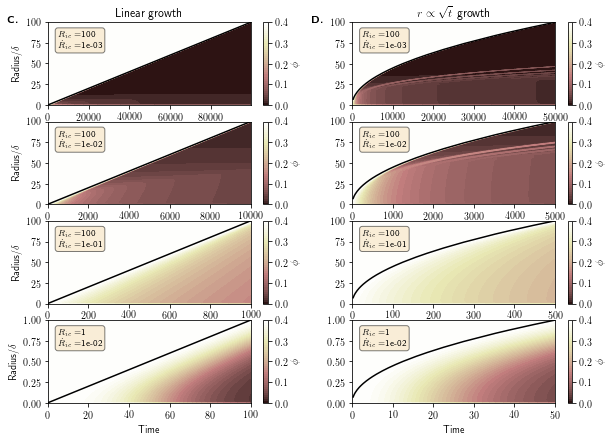

In [7]:
def figure_lineaire(folder, ax3, fig3):
    
    file_stat, param, timesteps = figures.extract_files(folder)
    name_max = max(timesteps.items(), key=itemgetter(1))[0]
    data = pd.read_csv(name_max, sep=" ")
    dr = data["radius"][1]-data["radius"][0]
    Radius = np.array(data["radius"].values)+ dr / 2.

    param["dot_r"] = param["Ric_adim"]/param["time_max"]*param["growth_rate_exponent"]

    Time = np.array(sorted(timesteps.values()))
        #print((Time))
    rayon = np.zeros_like(Time)    

    X, Y = np.meshgrid(Time, Radius)
    Z = 0.4*np.ones_like(X)
        #print(timesteps)
    for i, (name, time) in enumerate(sorted(timesteps.items(), key = itemgetter(1))):
        data = pd.read_csv(name, sep=" ")
        #Porosity = np.array(data["porosity"].values)
        #N_r = len(Porosity)
        dr = data["radius"][1]-data["radius"][0]
        Porosity = np.array(data["porosity"].values)
        N_r = len(Porosity)
        Z[:N_r, i] = Porosity
        rayon[i] = data["radius"].iloc[-1]

    #fig3, ax3 = plt.subplots(figsize=[10,3])
    levels = np.linspace(0, 0.4, 41)
    sc = ax3.contourf(X, Y, Z, levels=levels, vmin=0, vmax = 0.4, cmap=plt.cm.get_cmap("pink"))
    cb = fig3.colorbar(sc, ax=ax3, ticks=[0, 0.1, 0.2, 0.3, 0.4]) #, boundaries=np.linspace(0, 0.4, 6))
    #cb.set_clim(0, 0.4)
    ax3.set_xlim([0., time])
    ax3.plot(Time, rayon, 'k')
    cb.set_label("$\phi$")
    textstr = '\n'.join((
                    r"$R_{{ic}}=${:.0f}".format(param["Ric_adim"]),
                    r"$\dot R_{{ic}}=${:.0e}".format(param["dot_r"])))
    
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax3.text(0.05, 0.90, textstr, transform=ax3.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)
    #if folder == "/home/lasbleis-m/Research/output_mush/lotsoffigs/exp_5.00e-01_coeff_1.41e+00_radius_1.00e+02":
    #    fig, ax = plt.subplots()
    #    ax.plot(Time, param["dot_r"]*1/np.sqrt(Time/param["time_max"]))


base = "/home/lasbleis-m/Research/output_mush/lotsoffigs/"
folders = ["exp_1.00e+00_coeff_1.00e-03_radius_1.00e+02",
           "exp_1.00e+00_coeff_1.00e-02_radius_1.00e+02", 
           "exp_1.00e+00_coeff_1.00e-01_radius_1.00e+02",
           #"exp_1.00e+00_coeff_1.00e+00_radius_1.00e+02", 
           "exp_1.00e+00_coeff_1.00e-02_radius_1.00e+00"]
folders_05=["exp_5.00e-01_coeff_4.47e-01_radius_1.00e+02",
            "exp_5.00e-01_coeff_1.41e+00_radius_1.00e+02",
            "exp_5.00e-01_coeff_4.47e+00_radius_1.00e+02",
           #"exp_5.00e-01_coeff_1.41e+01_radius_1.00e+02",
           "exp_5.00e-01_coeff_1.41e-01_radius_1.00e+00"]

N_fig = len(folders)
fig, ax = plt.subplots(N_fig, 2, figsize=[10, 7])
#fig2, ax2 = plt.subplots(N_fig, 2, figsize=[10, 7])

for i, folder in enumerate(folders):
    
    figure_lineaire(base+folder, ax[i, 0], fig)
    figure_lineaire(base+folders_05[i], ax[i, 1], fig)
    
    
    ax[i, 0].set_ylabel("Radius/$\delta$")
    
    
    
    
ax[-1, 0].set_xlabel("Time")
ax[-1, 1].set_xlabel("Time")
ax[0, 0].set_title("Linear growth")
ax[0, 1].set_title(r"$r\propto\sqrt{t}$ growth")

ax[0, 0].text(-0.2, 1.10, r"\textbf{C.}", transform=ax[0, 0].transAxes, fontsize=11,
            verticalalignment='top')
ax[0, 1].text(-0.2, 1.10, r"\textbf{D.}", transform=ax[0, 1].transAxes, fontsize=11,
            verticalalignment='top')


plt.savefig("fig/different_growth.pdf", transparent=True, bbox_inches="tight")

# Scaling laws

First, select the global data set:

In [8]:
folder = "/home/lasbleis-m/Research/output_mush/scalinglaw/"


values = diagram_data_residual_porosity(folder, "diag.csv")
values["dot_r"] = values["Ric_adim"]/values["tau_ic"]*values["exp"] 
values["logdot_r"]=np.log10(values["dot_r"])
values["logr"]=np.log10(values["Ric_adim"])

print(values.columns)

Looking through folder /home/lasbleis-m/Research/output_mush/scalinglaw/


/home/lasbleis-m/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Run not finished for R 10.0, dot_R 1e-07: folder /home/lasbleis-m/Research/output_mush/scalinglaw//exp_1.00e+00_coeff_1.00e-07_radius_1.00e+01
5.05 10.0
Run not finished for R 3162.2776601683795, dot_R 0.001: folder /home/lasbleis-m/Research/output_mush/scalinglaw//exp_1.00e+00_coeff_1.00e-03_radius_3.16e+03
659.05 3162.2776601683795
Run not finished for R 1000.0, dot_R 0.3353628856001657: folder /home/lasbleis-m/Research/output_mush/scalinglaw//exp_5.00e-01_coeff_3.35e-01_radius_1.00e+03
201.8 1000.0
Run not finished for R 31.622776601683796, dot_R 0.07952707287670507: folder /home/lasbleis-m/Research/output_mush/scalinglaw//exp_5.00e-01_coeff_7.95e-02_radius_3.16e+01
12.684000000000001 31.622776601683796
Run not finished for R 31.622776601683793, dot_R 0.2514866859365871: folder /home/lasbleis-m/Research/output_mush/scalinglaw//exp_5.00e-01_coeff_2.51e-01_radius_3.16e+01
12.79 31.622776601683793
Run not finished for R 999.9999999999999, dot_R 1e-05: folder /home/lasbleis-m/Research/o

We predict that the residual porosity (at the center) scales as 

$$ \phi_c \propto (\tau_{ic}/Ric)^{1/1-n} $$

So to check, we plot $\phi_1 R_ic$, where $\phi_1$ is either the center porosity or the average porosity. 


## For linear growth

log dot r:  [-6.   -5.5  -5.   -4.5  -4.   -3.5  -3.   -2.   -1.75 -1.5  -1.25]
log radius:  [1.  1.5 2.  2.5 3. ]


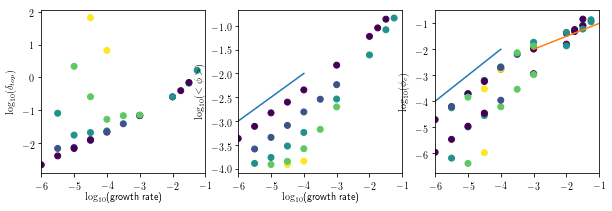

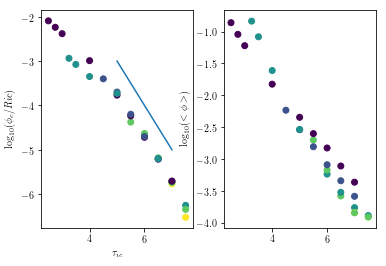

In [9]:
# select data for exp = 1
exp1 = values[values["exp"]==1.]
exp1 = exp1[exp1["Ric_adim"]>1.]
exp1 = exp1[exp1["logdot_r"]<-1.]

logR = np.log10(exp1["Ric_adim"])
logdot_r = np.log10(exp1["dot_r"])
logdelta = np.log10(exp1["delta"])
logphi = np.log10(exp1["sum_phi"])
logphir = np.log10(exp1["phi_r"])
logphit = np.log10(exp1["phi_top"])
tauic = np.log10(exp1["tau_ic"])

fig, ax = plt.subplots(1, 3, figsize=[10, 3])
sc = ax[1].scatter(logdot_r, logphi, c=logR)
sc = ax[2].scatter(logdot_r, logphir, c=logR)
sc = ax[2].scatter(logdot_r, logphit, c=logR)
ax[2].plot([-6, -4], [-4, -2])
#ax[2].plot([-6, -4], [-3.5, -2.5])
ax[2].plot([-3, -1], [-2, -1])
ax[1].plot([-6, -4], [-3, -2])
sc = ax[0].scatter(logdot_r, logdelta, c=logR)

ax[0].set_xlim([-6, -1])
#ax[0].set_ylim([-3, 1])
ax[1].set_xlim([-6, -1])
ax[2].set_xlim([-6, -1])
ax[0].set_xlabel("$\log_{10}$(growth rate)")
ax[0].set_ylabel("$\log_{10}(\delta_{top})$")
ax[1].set_xlabel("$\log_{10}$(growth rate)")
ax[1].set_ylabel("$\log_{10}(<\phi>)$")
ax[2].set_ylabel("$\log_{10}(\phi_c)$")

fig, ax = plt.subplots(1, 2)
ax[0].scatter(tauic, logphir-logR, c=logR)
ax[0].plot([5, 7], [-3, -5])
ax[1].scatter(tauic, logphi, c=logR)
ax[0].set_ylabel(r"$\log_{10}(\phi_c/Ric)$")
ax[1].set_ylabel(r"$\log_{10}(<\phi>)$")
ax[0].set_xlabel(r"$\tau_{ic}$")
#ax[1].plot([5, 7], [-3, -5])

print("log dot r: ", np.sort(exp1["logdot_r"].unique()))
print("log radius: ", np.sort(exp1["logr"].unique()))




## Profils at the end of the run

{'/home/lasbleis-m/Research/output_mush/scalinglaw/exp_5.00e-01_coeff_7.95e+00_radius_1.00e+03/output_15811.44377364.timestep': 15811.44377364, '/home/lasbleis-m/Research/output_mush/scalinglaw/exp_5.00e-01_coeff_7.95e+00_radius_1.00e+03/output_7905.71292113.timestep': 7905.71292113}
/home/lasbleis-m/Research/output_mush/scalinglaw/exp_5.00e-01_coeff_7.95e+00_radius_1.00e+03/output_15811.44377364.timestep
0.12217803448678133
{'/home/lasbleis-m/Research/output_mush/scalinglaw/exp_5.00e-01_coeff_7.95e-01_radius_1.00e+03/output_1581138.90005013.timestep': 1581138.90005013, '/home/lasbleis-m/Research/output_mush/scalinglaw/exp_5.00e-01_coeff_7.95e-01_radius_1.00e+03/output_790569.90005013.timestep': 790569.90005013}
/home/lasbleis-m/Research/output_mush/scalinglaw/exp_5.00e-01_coeff_7.95e-01_radius_1.00e+03/output_1581138.90005013.timestep
0.010558405686106996
{'/home/lasbleis-m/Research/output_mush/scalinglaw/exp_5.00e-01_coeff_4.47e+00_radius_1.00e+03/output_50000.17542038.timestep': 500

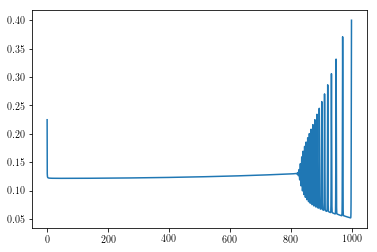

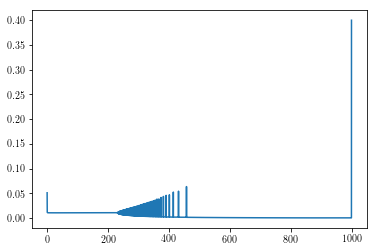

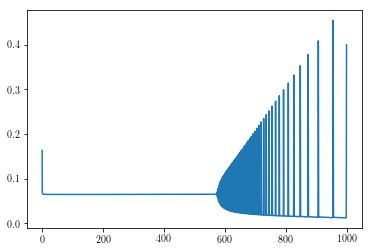

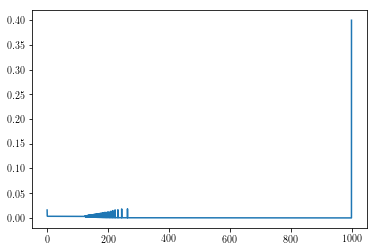

In [10]:
exp_05 = "/home/lasbleis-m/Research/output_mush/scalinglaw/exp_5.00e-01_coeff_1.41e+00_radius_1.00e+02"
profile_1 = "/home/lasbleis-m/Research/output_mush/scalinglaw/exp_5.00e-01_coeff_7.95e+00_radius_1.00e+03"
profile_2 = "/home/lasbleis-m/Research/output_mush/scalinglaw/exp_5.00e-01_coeff_7.95e-01_radius_1.00e+03"
profile_3 = "/home/lasbleis-m/Research/output_mush/scalinglaw/exp_5.00e-01_coeff_4.47e+00_radius_1.00e+03"
profile_4 = "/home/lasbleis-m/Research/output_mush/scalinglaw/exp_5.00e-01_coeff_2.51e-01_radius_1.00e+03"


exp_05 = "/home/lasbleis-m/Research/output_mush/scalinglaw/exp_5.00e-01_coeff_1.41e-01_radius_1.00e+01"
#exp_1 = "/home/lasbleis-m/Research/output_mush/scalinglaw/exp_1.00e+00_coeff_1.00e-03_radius_1.00e+02"


for folder in [profile_1, profile_2, profile_3, profile_4]: 
    file_stat, param, timesteps = figures.extract_files(folder)
    name_max = max(timesteps.items(), key=itemgetter(1))[0]
    data = pd.read_csv(name_max, sep=" ")
    dr = data["radius"][1]-data["radius"][0]
    Radius = np.array(data["radius"].values)+ dr / 2.

    param["dot_r"] = param["Ric_adim"]/param["time_max"]*param["growth_rate_exponent"]
    print(timesteps)
    print(name_max)
    
    data = pd.read_csv(name_max, sep=" ")
    dr = data["radius"][1]-data["radius"][0]
    
    fig, ax = plt.subplots()
    ax.plot((data["radius"]), (data["porosity"]))
    
    index = abs(data['radius'] - 5).idxmin()
    print(data["porosity"].iloc[index])
    

# For $\sqrt{t}$ growth

log dot r:  [-6.   -5.5  -5.   -4.5  -4.   -3.5  -3.   -2.   -1.75 -1.5  -1.25]
log radius:  [1.  1.5 2.  2.5 3. ]


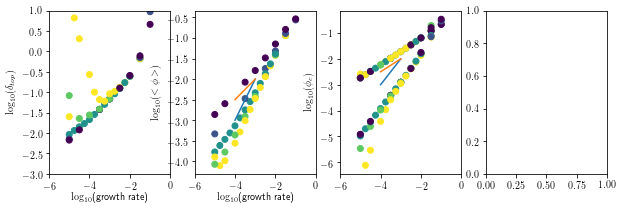

In [11]:
# select data for exp = 0.5
exp05 = values[values["exp"]==0.5]
exp05 = exp05[exp05["Nmax"]>10000]

logR = np.log10(exp05["Ric_adim"])
logdot_r = np.log10(exp05["dot_r"])
logdelta = np.log10(exp05["delta"])
logphi = np.log10(exp05["sum_phi"])
logphir = np.log10(exp05["phi_r"])
logphit = np.log10(exp05["phi_top"])
tauic = np.log10(exp05["tau_ic"])



fig, ax = plt.subplots(1, 4, figsize=[10, 3])
sc = ax[1].scatter(logdot_r, logphi, c=logR)
sc = ax[2].scatter(logdot_r, logphir, c=logR)
sc = ax[2].scatter(logdot_r, logphit, c=logR)
ax[2].plot([-4, -3], [-3, -2])
ax[2].plot([-4, -3], [-2.5, -2])
ax[1].plot([-4, -3], [-3, -2])
ax[1].plot([-4, -3], [-2.5, -2])
sc = ax[0].scatter(logdot_r, logdelta, c=logR)

ax[0].set_xlim([-6, 0])
ax[0].set_ylim([-3, 1])
ax[1].set_xlim([-6, 0])
ax[2].set_xlim([-6, 0])
ax[0].set_xlabel("$\log_{10}$(growth rate)")
ax[0].set_ylabel("$\log_{10}(\delta_{top})$")
ax[1].set_xlabel("$\log_{10}$(growth rate)")
ax[1].set_ylabel("$\log_{10}(<\phi>)$")
ax[2].set_ylabel("$\log_{10}(\phi_c)$")

#fig, ax = plt.subplots(1, 2)
#ax[0].scatter(tauic, logphir-logR, c=logR)
#ax[0].plot([3, 7], [-2, -6])
#ax[1].scatter(tauic, logphi, c=logR)
#ax[0].set_ylabel(r"$\log_{10}(\phi_c/Ric^{1/2})$")
#ax[1].set_ylabel(r"$\log_{10}(<\phi>)$")
#ax[0].set_xlabel(r"$\tau_{ic}$")
#ax[1].plot([5, 7], [-3, -5])

print("log dot r: ", np.sort(exp1["logdot_r"].unique()))
print("log radius: ", np.sort(exp1["logr"].unique()))

Text(-0.2, 1.1, '\\textbf{C.}')

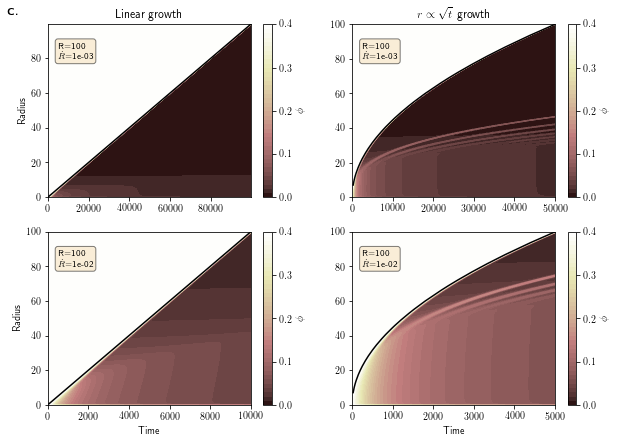

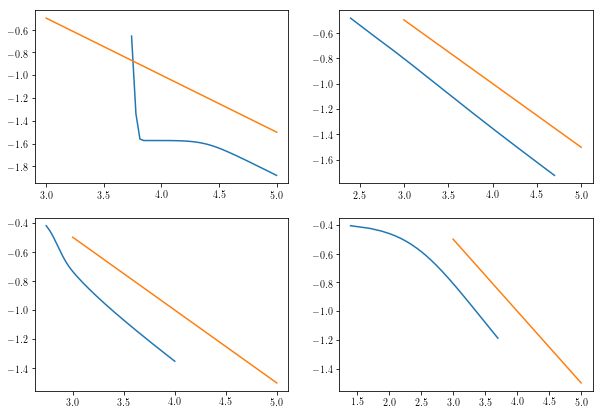

In [12]:
def figure_lineaire(folder, ax3, fig3, ax, fig):
    
    file_stat, param, timesteps = figures.extract_files(folder)
    name_max = max(timesteps.items(), key=itemgetter(1))[0]
    data = pd.read_csv(name_max, sep=" ")
    dr = data["radius"][1]-data["radius"][0]
    Radius = np.array(data["radius"].values)+ dr / 2.

    param["dot_r"] = param["Ric_adim"]/param["time_max"]*param["growth_rate_exponent"]

    Time = np.array(sorted(timesteps.values()))
        #print((Time))
    rayon = np.zeros_like(Time)    
    base_porosity = np.zeros_like(Time)
    
    X, Y = np.meshgrid(Time, Radius)
    Z = 0.4*np.ones_like(X)
        #print(timesteps)
    for i, (name, time) in enumerate(sorted(timesteps.items(), key = itemgetter(1))):
        data = pd.read_csv(name, sep=" ")
        #Porosity = np.array(data["porosity"].values)
        #N_r = len(Porosity)
        dr = data["radius"][1]-data["radius"][0]
        Porosity = np.array(data["porosity"].values)
        N_r = len(Porosity)
        Z[:N_r, i] = Porosity
        rayon[i] = data["radius"].iloc[-1]
            
        index = abs(data['radius'] - 0.05*param["Ric_adim"]).idxmin()
        base_porosity[i] = data["porosity"].iloc[index]
        # print(data["porosity"].iloc[index])

    #fig3, ax3 = plt.subplots(figsize=[10,3])
    levels = np.linspace(0, 0.4, 41)
    sc = ax3.contourf(X, Y, Z, levels=levels, vmin=0, vmax = 0.4, cmap=plt.cm.get_cmap("pink"))
    cb = fig3.colorbar(sc, ax=ax3, ticks=[0, 0.1, 0.2, 0.3, 0.4]) #, boundaries=np.linspace(0, 0.4, 6))
    #cb.set_clim(0, 0.4)
    ax3.set_xlim([0., time])
    ax3.plot(Time, rayon, 'k')
    cb.set_label("$\phi$")
    textstr = '\n'.join((
                    r"R={:.0f}".format(param["Ric_adim"]),
                    r"$\dot R$={:.0e}".format(param["dot_r"])))
    
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax3.text(0.05, 0.90, textstr, transform=ax3.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)
    
    ax.plot(np.log10(Time), np.log10(base_porosity))
    ax.plot([3, 5], [-0.5, -1.5])
    
    
    
    



base = "/home/lasbleis-m/Research/output_mush/lotsoffigs/"
folders = ["exp_1.00e+00_coeff_1.00e-03_radius_1.00e+02",
           "exp_1.00e+00_coeff_1.00e-02_radius_1.00e+02"]#, 
           #"exp_1.00e+00_coeff_1.00e-01_radius_1.00e+02",
           #"exp_1.00e+00_coeff_1.00e+00_radius_1.00e+02", 
           #"exp_1.00e+00_coeff_1.00e-02_radius_1.00e+00"]
folders_05=["exp_5.00e-01_coeff_4.47e-01_radius_1.00e+02",
            "exp_5.00e-01_coeff_1.41e+00_radius_1.00e+02"]#,
           # "exp_5.00e-01_coeff_4.47e+00_radius_1.00e+02",
           #"exp_5.00e-01_coeff_1.41e+01_radius_1.00e+02",
           #"exp_5.00e-01_coeff_1.41e-01_radius_1.00e+00"]

N_fig = len(folders)
fig, ax = plt.subplots(N_fig, 2, figsize=[10, 7])
fig2, ax2 = plt.subplots(N_fig, 2, figsize=[10, 7])

for i, folder in enumerate(folders):
    
    figure_lineaire(base+folder, ax[i, 0], fig, ax2[i, 0], fig2)
    figure_lineaire(base+folders_05[i], ax[i, 1], fig, ax2[i, 1], fig2)
    
    ax[i, 0].set_ylabel("Radius")
    
    
    
ax[-1, 0].set_xlabel("Time")
ax[-1, 1].set_xlabel("Time")
ax[0, 0].set_title("Linear growth")
ax[0, 1].set_title(r"$r\propto\sqrt{t}$ growth")

ax[0, 0].text(-0.2, 1.10, r"\textbf{C.}", transform=ax[0, 0].transAxes, fontsize=11,
            verticalalignment='top')


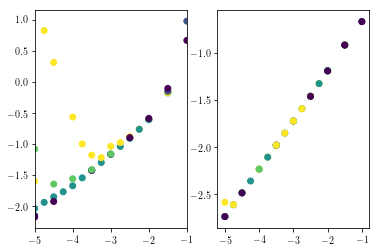

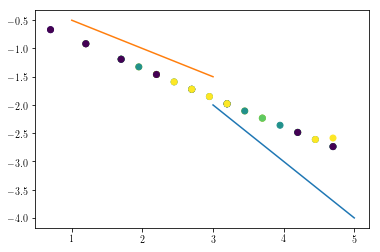

In [13]:
# select data for exp = 1
exp1 = values[values["exp"]==0.5]
#exp1 = exp1[exp1["Ric_adim"]>1.]

logR = np.log10(exp1["Ric_adim"])
logdot_r = np.log10(exp1["dot_r"])
logdelta = np.log10(exp1["delta"])
logphi = np.log10(exp1["sum_phi"])
tauic = np.log10(exp1["tau_ic"])
logphir = np.log10(exp1["phi_r"])

fig, ax = plt.subplots(1, 2)
sc = ax[1].scatter(logdot_r, logphir, c=logR)
sc = ax[0].scatter(logdot_r, logdelta, c=logR)

ax[0].set_xlim([-5, -1])

fig, ax = plt.subplots()
ax.scatter(tauic-logR, logphir, c=logR)
ax.plot([3, 5], [-2, -4])
ax.plot([1, 3], [-0.5, -1.5])